In [1]:
import numpy as np
import pandas as pd
from bch import BCH
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [3]:
assume = lambda x: 0 if abs(x - 0) < abs(x - 1) else 1
wherediff = lambda a, b: np.where(a != b)[0]
gen_noise = lambda shape, amt: (np.random.rand(*shape) - 0.5) * amt

In [4]:
def gen_U_eqbits(n_msg, k):
    """
    сгенерировать м-цу из n_msg сбщ длины k,
    в которой значения 0 и 1 распределены равномерно
    """
    return np.random.choice(2, (n_msg, k))

def gen_U_eqnorms(n_msg, k):
    """
    сгенерировать м-цу из n_msg сбщ длины k,
    в которой кол-ва единиц в одном сообщении распределены равномерно
    
    но во всей матрице в итоге биты встречаются с одинаковой вероятностью
    """
    n_ones_list = np.random.randint(0, k + 1, n_msg)
    U = np.array([
        np.concatenate((np.ones(n_ones, dtype=int),
                        np.zeros(k - n_ones, dtype=int)))
        for n_ones in n_ones_list
    ])
    for u in U:
        np.random.shuffle(u)
    return U

In [5]:
def get_amt_for_t(n, amt_range, percent, n_tests=10000):
    """
    решается задача: подбирать для заданного t такое значение мощности шума,
    чтобы примерно в percent % сообщений было до t ошибок (а в остальных - больше t)
    
    функция возвращает два вектора:
    amt_for_t - вектор amt, соответствующих t=0,1,... (до последнего amt в amt_range)
    t_for_amt - вектор соответствующих t для элементов из amt_range
      (amt_range - возрастающая посл-ть значений amt)
    """
    V = gen_U_eqnorms(n_tests, n)
    t_for_amt = []
    t = -1
    for amt in amt_range:
        noise = gen_noise((n_tests, n), amt)
        W = np.vectorize(assume)(V + noise)
        n_err_list = [len(wherediff(v, w)) for v, w in zip(V, W)]
        t = max(t, np.percentile(n_err_list, percent))
        t_for_amt.append(t)
        print('.', end='')
    print('*')
    t_for_amt = np.array(t_for_amt).astype(int)
    max_t = t_for_amt[-1]
    amt_for_t = np.array(amt_range)[
        [np.searchsorted(t_for_amt, j, 'left')
         for j in range(max_t + 1)]
    ]
    return amt_for_t, t_for_amt

In [6]:
def trim_err(W, V, t):
    # W - зашумленная версия V
    # вернуть копию W, в которой число ошибок в каждом сообщении <= t
    #   (для этого в сообщениях с большим числом ошибок исправляется столько
    #   ошибок, чтобы всего было ровно t)
    W_ = np.copy(W)
#     n_overdrives = 0
    for i, (v, w) in enumerate(zip(V, W_)):
        err_idx = wherediff(v, w)
        n_err = len(err_idx)
        if n_err > t:
#             n_overdrives += 1
            np.random.shuffle(err_idx)
            W_[i, err_idx[t : ]] ^= 1
            n_err = t
            if len(wherediff(v, W_[i])) != t:
                raise Exception("programmer error")
#     print("n_overdrives / n_msg:", n_overdrives / len(W))
    return W_

In [7]:
def count_overdrives(W, V, t):
    n_err_list = np.array([len(wherediff(v, w)) for v, w in zip(V, W)])
    n_overdrives = (n_err_list > t).sum()
    return n_overdrives

In [8]:
def decoders_test(n_list, n_msg, amt_for_t, df_for_n, trim=True):
    chars = []
    for n, amt_for_t in zip(n_list, amt_for_t_for_n):
        t_values = df_for_n.get_group(n).t.values
        max_t = len(amt_for_t) - 1
        t_values = t_values[:-1]
        t_values = t_values[t_values <= max_t]
        amts = amt_for_t[t_values]
        bch = None
        for t, amt in zip(t_values, amts):
            np.random.seed(123)
            bch_copy = bch
            bch = BCH(n, t, ref=bch_copy)
            k = bch.k
            print(f"n = {n}, t = {t}, k = {k}, speed = {k/n:.2} ({k}/{n})")
            U = gen_U_eqnorms(n_msg, k)
            V = bch.encode(U)
            noise = gen_noise((n_msg, n), amt)
            W = np.vectorize(assume)(V + noise)
            if trim:
                W = trim_err(W, V, t)
                n_overdrives = 0
            else:
                n_overdrives = count_overdrives(W, V, t)
                print("n_overdrives =", n_overdrives)
            Vd1 = bch.decode(W, method='pgz')
            time_pgz = bch.time
            Vd2 = bch.decode(W, method='euclid')
            time_euclid = bch.time
            bch_char = [(n, t), n_overdrives, [0,0,0], [0,0,0], time_pgz, time_euclid]
            for vd1, vd2, v in zip(Vd1, Vd2, V):
                for met_char, vd, method in zip(bch_char[2:4], [vd1, vd2], ['pgz', 'euclid']):
                    if np.isnan(vd).any():
                        met_char[2] += 1
                    else: 
                        if np.array_equal(vd, v):
                            met_char[0] += 1
                        else:
                            met_char[1] += 1
            chars.append(bch_char)
            print(bch_char)
            print()
    return chars

In [9]:
def decoders_err_hist(n_list, n_msg, amt_for_t, df_for_n, trim=True, text=None):
    chars = []
    for n, amt_for_t in zip(n_list, amt_for_t_for_n):
        t_values = df_for_n.get_group(n).t.values
        max_t = len(amt_for_t) - 1
        t_values = t_values[:-1]
        t_values = t_values[t_values <= max_t]
        amts = amt_for_t[t_values]
        bch = None
        for t, amt in zip(t_values, amts):
            np.random.seed(123)
            bch_copy = bch
            bch = BCH(n, t, ref=bch_copy)
            k = bch.k
            U = gen_U_eqnorms(n_msg, k)
            V = bch.encode(U)
            noise = gen_noise((n_msg, n), amt)
            W = np.vectorize(assume)(V + noise)
            if trim:
                W = trim_err(W, V, t)
                n_overdrives = 0
            else:
                n_overdrives = count_overdrives(W, V, t)
            n_err_list = np.array([len(wherediff(v, w)) for v, w in zip(V, W)]).astype(int)
            hist_end = max(max(n_err_list), 4 * t)
            plt.figure(figsize=(5,5))
            plt.hist(n_err_list, bins=max(n_err_list) - min(n_err_list))
            plt.xlabel(f'n={n}, t={t}' + (f' ({text})' if text is not None else ''))
            plt.xticks(range(0, hist_end), labels=[f't={t}' if x == t else '' for x in range(0, hist_end)])
            plt.axvline(x=t, color='purple')

In [10]:
df = pd.read_csv("bch_table.csv", sep=',', index_col=0)
df_for_n = df.groupby(df.n)
df.head()

,n,k,t,speed,g
0,7,4,1,0.571429,B
1,7,1,3,0.142857,7F
2,15,11,1,0.733333,13
3,15,7,2,0.466667,1D1
4,15,5,3,0.333333,537


In [6]:
n_msg = 10000 # для всех трех тестов

..............................................................*
..............................................................*
..............................................................*
..............................................................*


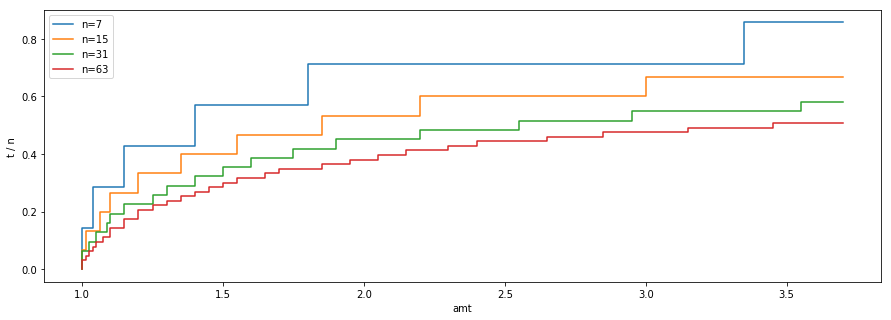

In [86]:
# первый тест - выбираем перцентиль 99
#   и исправляем лишние ошибки
percent = 99
n_list = [7, 15, 31, 63]
plt.figure(figsize=(15,5))
amt_for_t_for_n = []
for n in n_list:
    amts = np.concatenate((
        np.arange(1, 1.10, 0.0125),
        np.arange(1.10, 3.75, 0.05)
    ))
    amt_for_t, t_for_amt = get_amt_for_t(
        n=n,
        amt_range=amts,
        percent=percent,
        n_tests=10000,
    )
    plt.step(amts, t_for_amt / n, label=f'n={n}')
    amt_for_t_for_n.append(amt_for_t)
plt.xlabel('amt')
plt.ylabel('t / n')
plt.legend()

In [87]:
print(*amt_for_t_for_n, sep='\n')
print()
for n, amt_for_t in zip(n_list, amt_for_t_for_n):
    print(len(amt_for_t) - 1, df_for_n.get_group(n).t.values)

[1.     1.0125 1.05   1.2    1.45   1.85   3.4   ]
[1.     1.0125 1.025  1.075  1.15   1.25   1.4    1.6    1.9    2.25
 3.05  ]
[1.     1.0125 1.0125 1.0375 1.0625 1.1    1.15   1.2    1.3    1.35
 1.45   1.55   1.65   1.8    1.95   2.25   2.6    3.     3.6   ]
[1.     1.0125 1.0125 1.025  1.0375 1.05   1.0625 1.0875 1.15   1.15
 1.2    1.2    1.25   1.25   1.3    1.35   1.4    1.45   1.5    1.55
 1.6    1.7    1.75   1.9    2.     2.1    2.2    2.35   2.45   2.7
 2.9    3.2    3.5   ]

6 [1 3]
10 [1 2 3 7]
18 [ 1  2  3  5  7 15]
32 [ 1  2  3  4  5  6  7 10 11 13 15 31]


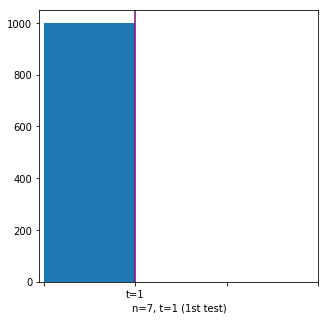

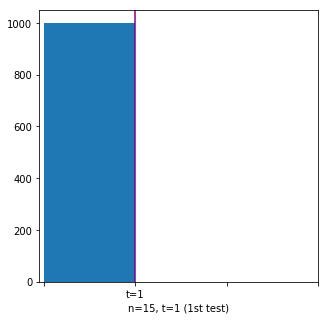

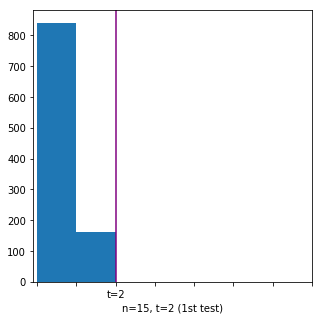

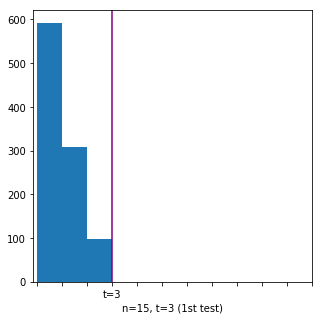

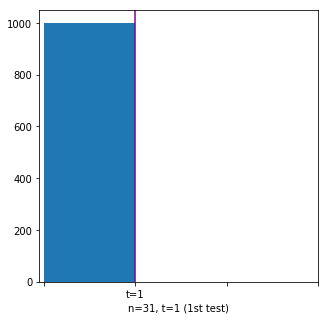

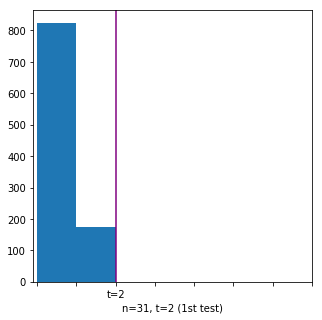

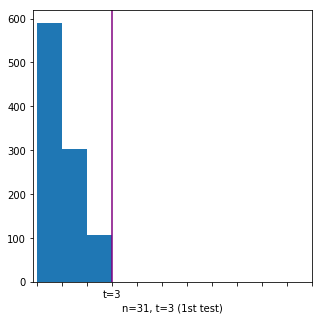

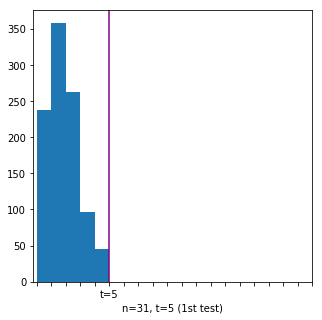

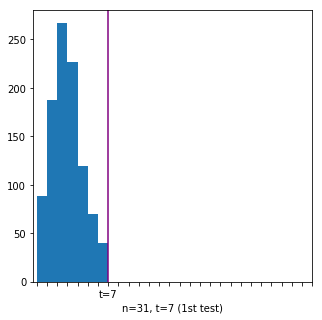

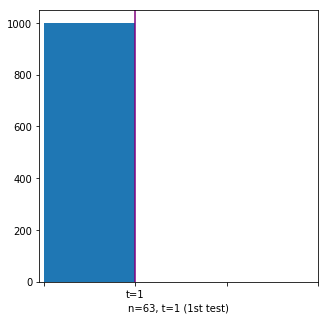

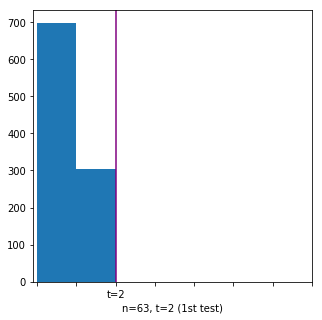

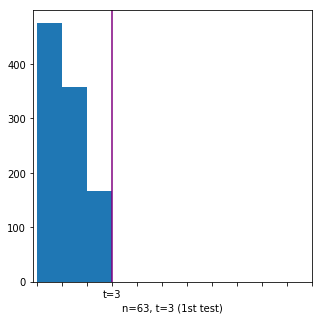

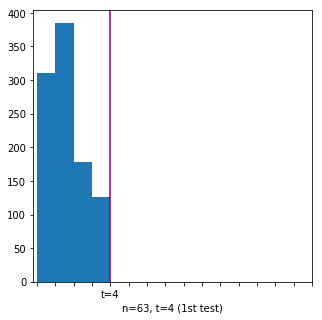

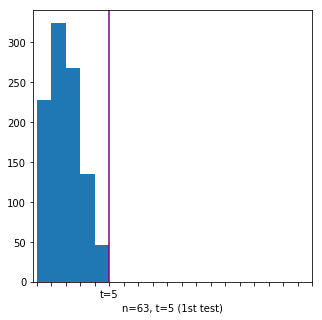

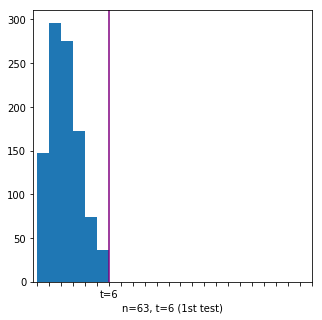

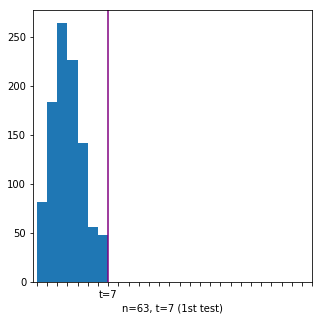

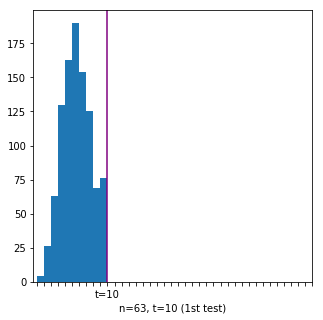

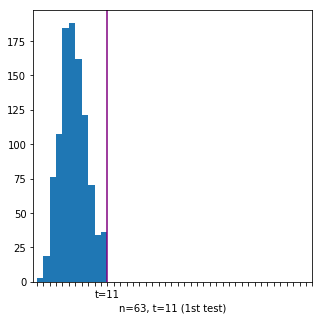

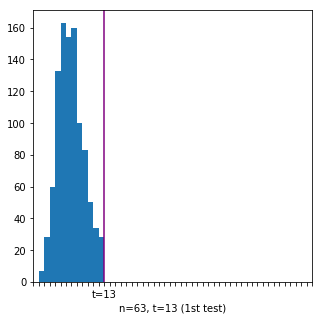

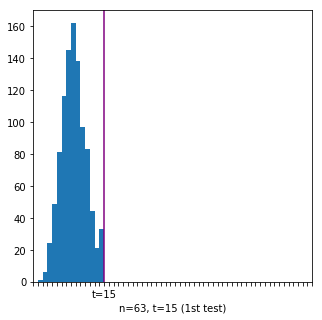

In [88]:
decoders_err_hist(n_list, 1000, amt_for_t, df_for_n, trim=True, text='1st test')

In [ ]:
bch_chars = decoders_test(n_list, n_msg, amt_for_t, df_for_n, trim=True)

..............................................................*
..............................................................*
..............................................................*
..............................................................*


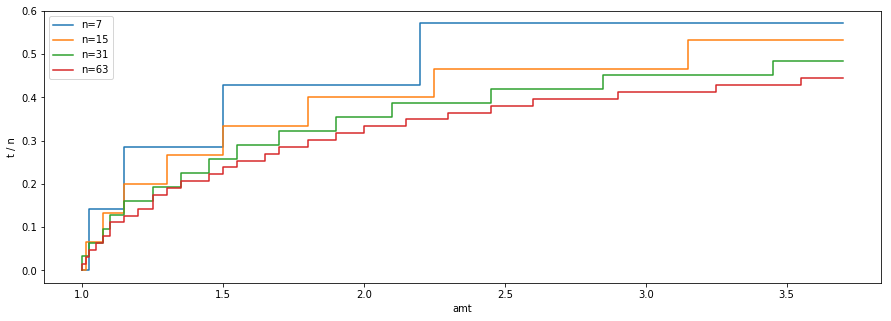

In [12]:
# второй тест - с ошибками, превышающие способность кода
# отличие: выбираем перцентиль 90, а также не исправляем лишние ошибки
percent = 90
n_list = [7, 15, 31, 63]
plt.figure(figsize=(15,5))
amt_for_t_for_n = []
for n in n_list:
    amts = np.concatenate((
        np.arange(1, 1.10, 0.0125),
        np.arange(1.10, 3.75, 0.05)
    ))
    amt_for_t, t_for_amt = get_amt_for_t(
        n=n,
        amt_range=amts,
        percent=percent,
        n_tests=10000,
    )
    plt.step(amts, t_for_amt / n, label=f'n={n}')
    amt_for_t_for_n.append(amt_for_t)
plt.xlabel('amt')
plt.ylabel('t / n')
plt.legend()

In [13]:
print(*amt_for_t_for_n, sep='\n')
print()
for n, amt_for_t in zip(n_list, amt_for_t_for_n):
    print(len(amt_for_t) - 1, df_for_n.get_group(n).t.values)

[1.     1.0375 1.2    1.55   2.25  ]
[1.     1.025  1.0875 1.2    1.35   1.55   1.85   2.3    3.2   ]
[1.     1.0125 1.0375 1.0875 1.15   1.2    1.3    1.4    1.5    1.6
 1.75   1.95   2.15   2.5    2.9    3.5   ]
[1.     1.0125 1.025  1.0375 1.0625 1.0875 1.15   1.15   1.2    1.25
 1.3    1.3    1.35   1.4    1.5    1.55   1.6    1.7    1.75   1.85
 1.95   2.05   2.2    2.35   2.5    2.65   2.95   3.3    3.6   ]

4 [1 3]
8 [1 2 3 7]
15 [ 1  2  3  5  7 15]
28 [ 1  2  3  4  5  6  7 10 11 13 15 31]


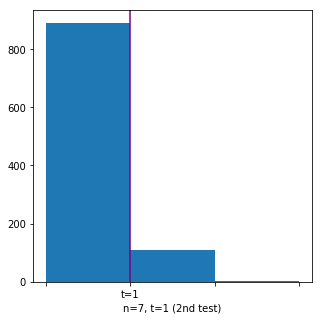

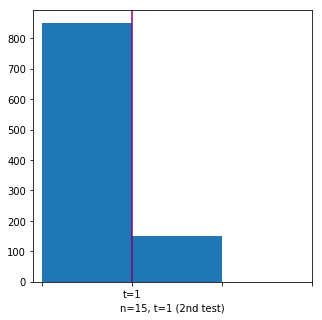

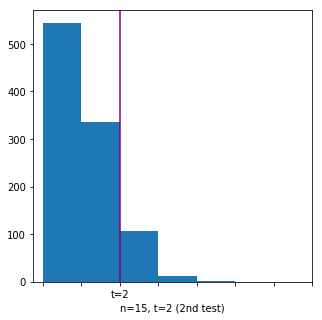

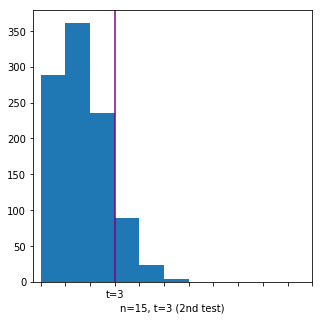

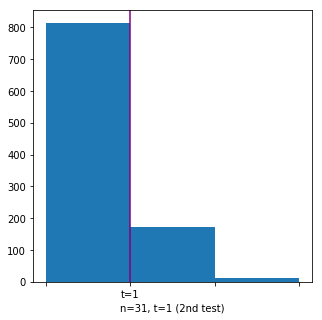

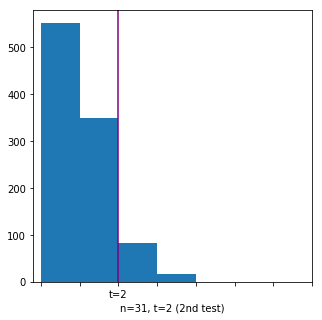

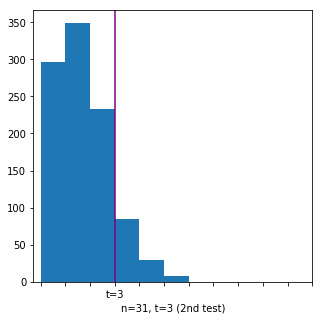

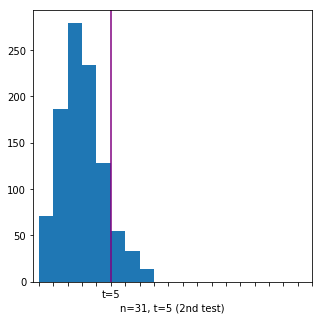

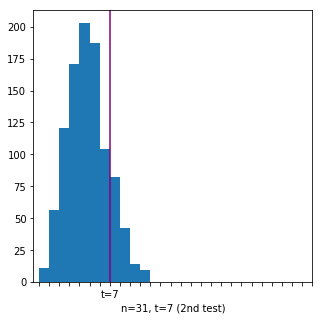

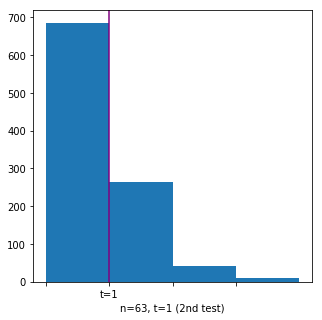

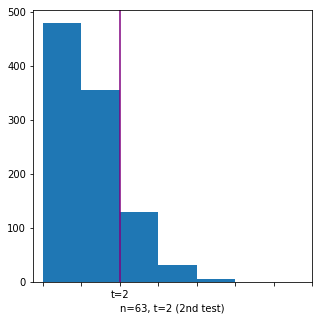

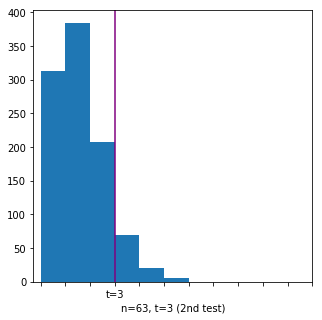

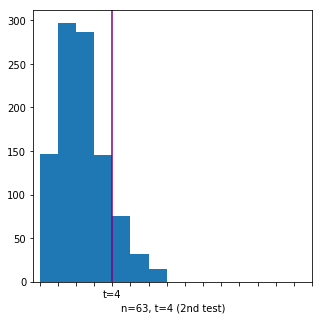

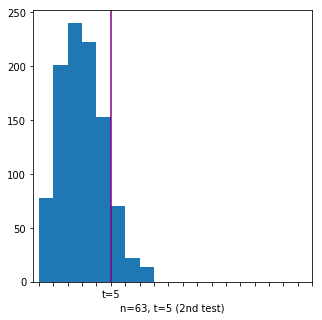

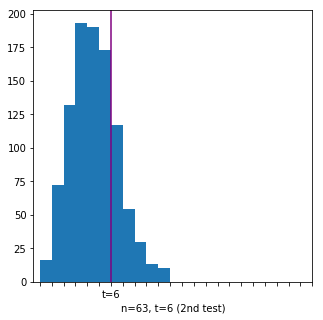

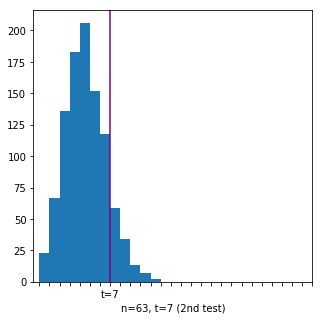

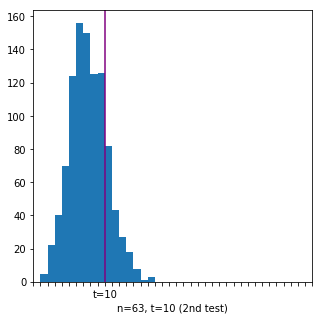

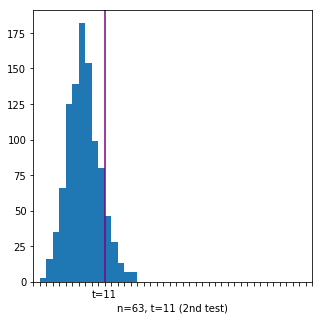

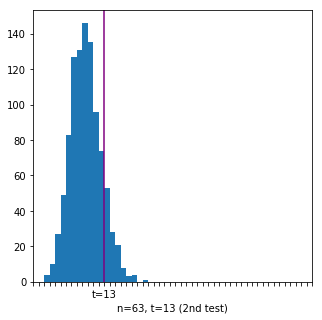

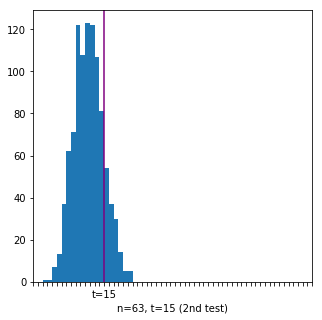

In [14]:
decoders_err_hist(n_list, 1000, amt_for_t, df_for_n, trim=False, text='2nd test')

In [ ]:
bch_chars_2 = decoders_test(n_list, n_msg, amt_for_t, df_for_n, trim=False)

..............................................................*
..............................................................*
..............................................................*
..............................................................*


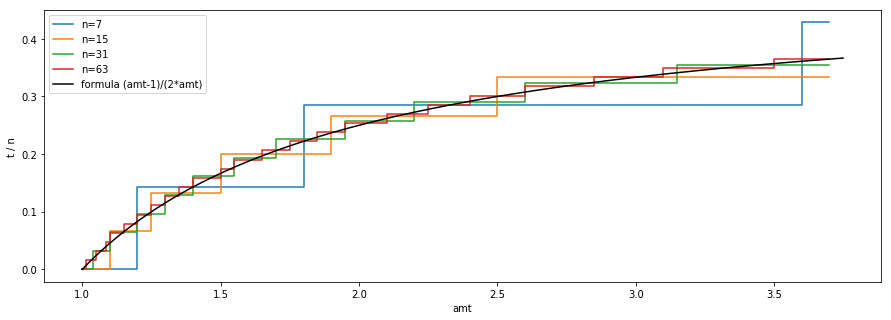

In [95]:
# третий тест - может быть ещё больше ошибок в сообщении, чем в прошлом тесте
#   выбираем перцентиль 50, не исправляем лишние ошибки
percent = 50
n_list = [7, 15, 31, 63]
plt.figure(figsize=(15,5))
amt_for_t_for_n = []
for n in n_list:
    amts = np.concatenate((
        np.arange(1, 1.10, 0.0125),
        np.arange(1.10, 3.75, 0.05)
    ))
    amt_for_t, t_for_amt = get_amt_for_t(
        n=n,
        amt_range=amts,
        percent=percent,
        n_tests=10000,
    )
    plt.step(amts, t_for_amt / n, label=f'n={n}')
    amt_for_t_for_n.append(amt_for_t)
prob = lambda amt: (amt - 1) / 2 / amt
x = np.arange(1, 3.75, 0.001)
plt.plot(x, prob(x), color='black', label='formula (amt-1)/(2*amt)')
plt.xlabel('amt')
plt.ylabel('t / n')
plt.legend()

In [96]:
print(*amt_for_t_for_n, sep='\n')
print()
get_amt_50 = lambda t, n: 1 / (1 - 2*t/n)
print(get_amt_50(np.arange(0,len(amt_for_t_for_n[0])), 7))
print(get_amt_50(np.arange(0,len(amt_for_t_for_n[1])), 15))
print(get_amt_50(np.arange(0,len(amt_for_t_for_n[2])), 31))
print(get_amt_50(np.arange(0,len(amt_for_t_for_n[3])), 63))
print()
for n, amt_for_t in zip(n_list, amt_for_t_for_n):
    print(len(amt_for_t) - 1, df_for_n.get_group(n).t.values)

[1.   1.25 1.85 3.65]
[1.   1.1  1.3  1.55 1.95 2.55]
[1.   1.05 1.15 1.25 1.35 1.45 1.6  1.75 2.   2.25 2.65 3.2 ]
[1.     1.025  1.0625 1.1    1.15   1.2    1.25   1.3    1.35   1.4
 1.45   1.55   1.6    1.7    1.8    1.9    2.     2.15   2.3    2.45
 2.65   2.9    3.15   3.55  ]

[1.         1.4        2.33333333 7.        ]
[1.         1.15384615 1.36363636 1.66666667 2.14285714 3.        ]
[1.         1.06896552 1.14814815 1.24       1.34782609 1.47619048
 1.63157895 1.82352941 2.06666667 2.38461538 2.81818182 3.44444444]
[1.         1.03278689 1.06779661 1.10526316 1.14545455 1.18867925
 1.23529412 1.28571429 1.34042553 1.4        1.46511628 1.53658537
 1.61538462 1.7027027  1.8        1.90909091 2.03225806 2.17241379
 2.33333333 2.52       2.73913043 3.         3.31578947 3.70588235]

3 [1 3]
5 [1 2 3 7]
11 [ 1  2  3  5  7 15]
23 [ 1  2  3  4  5  6  7 10 11 13 15 31]


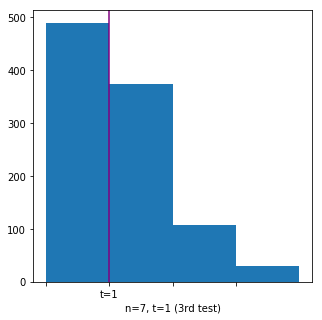

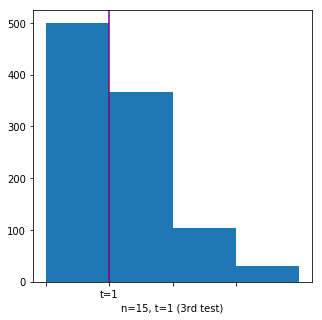

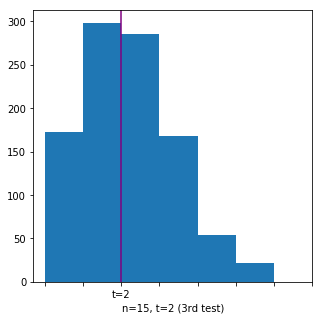

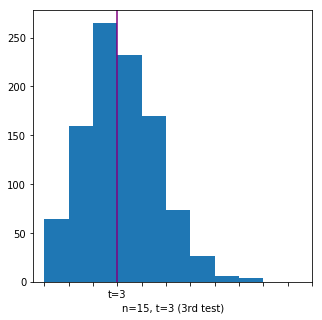

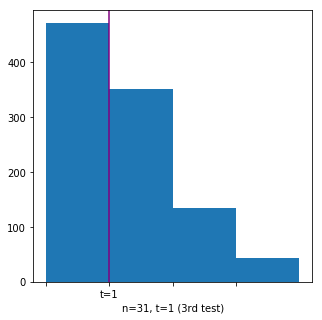

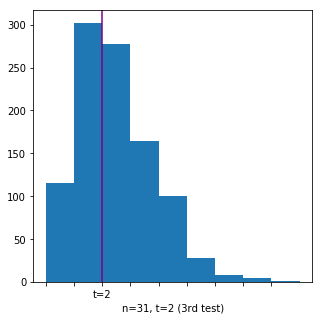

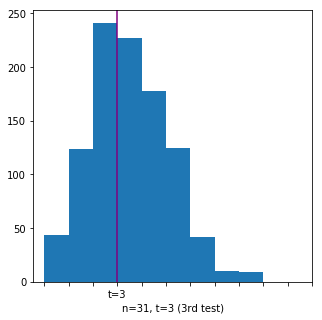

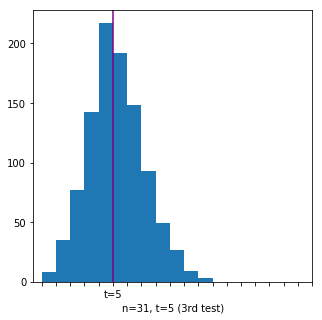

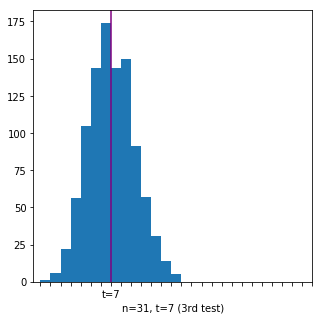

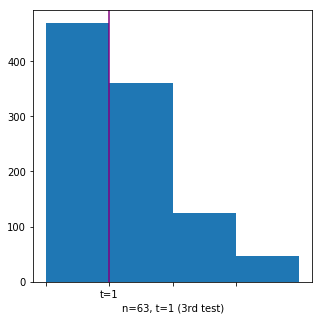

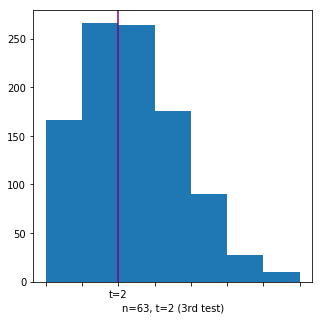

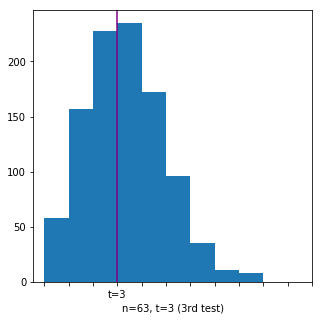

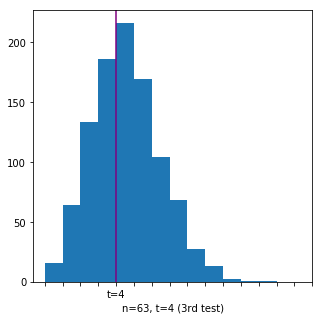

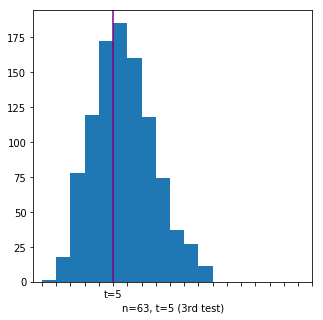

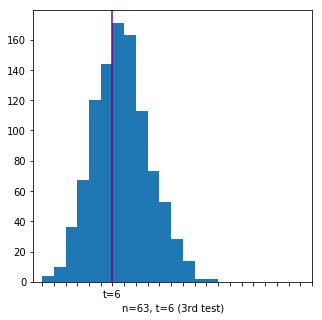

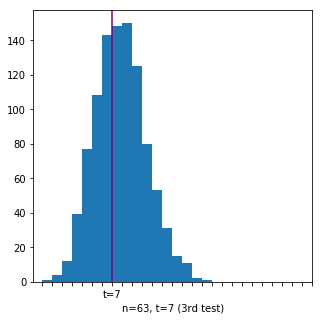

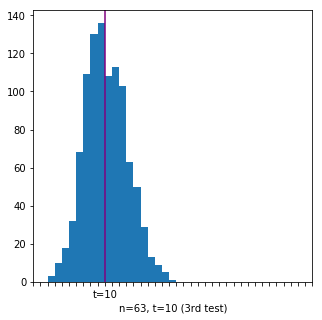

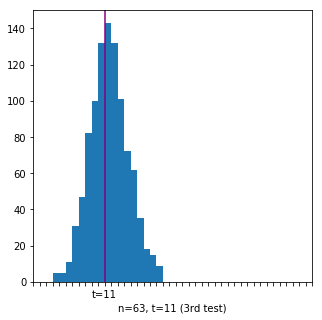

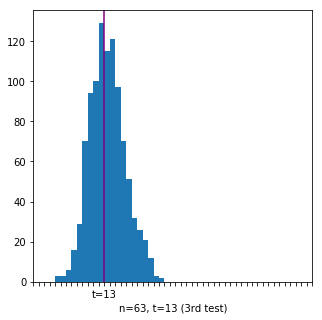

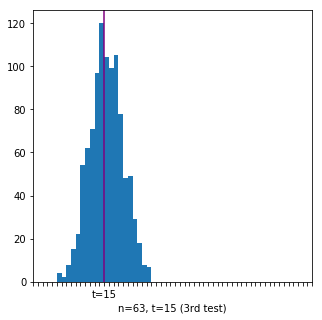

In [97]:
decoders_err_hist(n_list, 1000, amt_for_t, df_for_n, trim=False, text='3rd test')

In [ ]:
bch_chars_3 = decoders_test(n_list, n_msg, amt_for_t, df_for_n, trim=False)

In [99]:
table = []
for b1, b2, b3 in zip(bch_chars, bch_chars_2, bch_chars_3):
    for i, bch_inst in enumerate([b1, b2, b3]):
        table.append([
            *bch_inst[0],
            i + 1,
            bch_inst[1],
            *bch_inst[2],
            *bch_inst[3],
            *bch_inst[4:],
        ])

In [128]:
df_tests = pd.DataFrame(data=np.array(table), columns=["n","t","test","n_overdrives","pgz_n_succ","pgz_n_err","pgz_n_refuse","euclid_n_succ","euclid_n_err","euclid_n_refuse","pgz_time","euclid_time"])

In [129]:
for col in ["n", "t", "test", "n_overdrives",
            "pgz_n_succ", "pgz_n_err", "pgz_n_refuse",
            "euclid_n_succ", "euclid_n_err", "euclid_n_refuse",
           ]:
    df_tests[col] = df_tests[col].astype(int)

In [130]:
df_tests

,n,t,test,n_overdrives,pgz_n_succ,pgz_n_err,pgz_n_refuse,euclid_n_succ,euclid_n_err,euclid_n_refuse,pgz_time,euclid_time
0,7,1,1,0,10000,0,0,10000,0,0,0.053358,0.203457
1,7,1,2,73,9927,73,0,9927,73,0,0.162503,0.619373
2,7,1,3,1494,8506,1494,0,8506,1494,0,0.601855,2.322008
3,15,1,1,0,10000,0,0,10000,0,0,0.110557,0.412387
4,15,1,2,117,9883,117,0,9883,117,0,0.210682,0.766882
5,15,1,3,1420,8580,1420,0,8580,1420,0,0.591846,2.271186
6,15,2,1,0,10000,0,0,10000,0,0,0.491396,0.875439
7,15,2,2,212,9788,85,127,9788,85,127,1.306225,2.579588
8,15,2,3,2457,7543,934,1523,7543,934,1523,2.399009,5.650297
9,15,3,1,0,10000,0,0,10000,0,0,2.051725,2.412509


In [131]:
df_tests.to_csv("decode_tests_table.csv", sep=',')

In [2]:
df_tests = pd.read_csv("decode_tests_table.csv", sep=',', index_col=0)

In [3]:
df_tests["pgz_err_ratio"] = df_tests["pgz_n_err"] / df_tests.n_overdrives
df_tests["pgz_ref_ratio"] = df_tests["pgz_n_refuse"] / df_tests.n_overdrives
df_tests["euclid_err_ratio"] = df_tests["euclid_n_err"] / df_tests.n_overdrives
df_tests["euclid_ref_ratio"] = df_tests["euclid_n_refuse"] / df_tests.n_overdrives

In [7]:
print((df_tests.pgz_n_succ + df_tests.n_overdrives == n_msg).all())
print((df_tests.euclid_n_succ + df_tests.n_overdrives == n_msg).all())

True
True


In [8]:
df_er = df_tests[df_tests.test != 1][["n","t","test","n_overdrives",
                                "pgz_err_ratio","pgz_ref_ratio",
                                "euclid_err_ratio","euclid_ref_ratio"]]
df_er

,n,t,test,n_overdrives,pgz_err_ratio,pgz_ref_ratio,euclid_err_ratio,euclid_ref_ratio
1,7,1,2,73,1.000000,0.000000,1.000000,0.000000
2,7,1,3,1494,1.000000,0.000000,1.000000,0.000000
4,15,1,2,117,1.000000,0.000000,1.000000,0.000000
5,15,1,3,1420,1.000000,0.000000,1.000000,0.000000
7,15,2,2,212,0.400943,0.599057,0.400943,0.599057
8,15,2,3,2457,0.380138,0.619862,0.380138,0.619862
10,15,3,2,300,0.413333,0.586667,0.413333,0.586667
11,15,3,3,2589,0.415604,0.584396,0.415604,0.584396
13,31,1,2,148,1.000000,0.000000,1.000000,0.000000
14,31,1,3,1701,1.000000,0.000000,1.000000,0.000000


In [9]:
print((df_er.pgz_err_ratio == df_er.euclid_err_ratio).all())
print((df_er.pgz_ref_ratio == df_er.euclid_ref_ratio).all())

True
True


In [10]:
df_tests[["n","t","test","n_overdrives","pgz_time","euclid_time"]]

,n,t,test,n_overdrives,pgz_time,euclid_time
0,7,1,1,0,0.053358,0.203457
1,7,1,2,73,0.162503,0.619373
2,7,1,3,1494,0.601855,2.322008
3,15,1,1,0,0.110557,0.412387
4,15,1,2,117,0.210682,0.766882
5,15,1,3,1420,0.591846,2.271186
6,15,2,1,0,0.491396,0.875439
7,15,2,2,212,1.306225,2.579588
8,15,2,3,2457,2.399009,5.650297
9,15,3,1,0,2.051725,2.412509


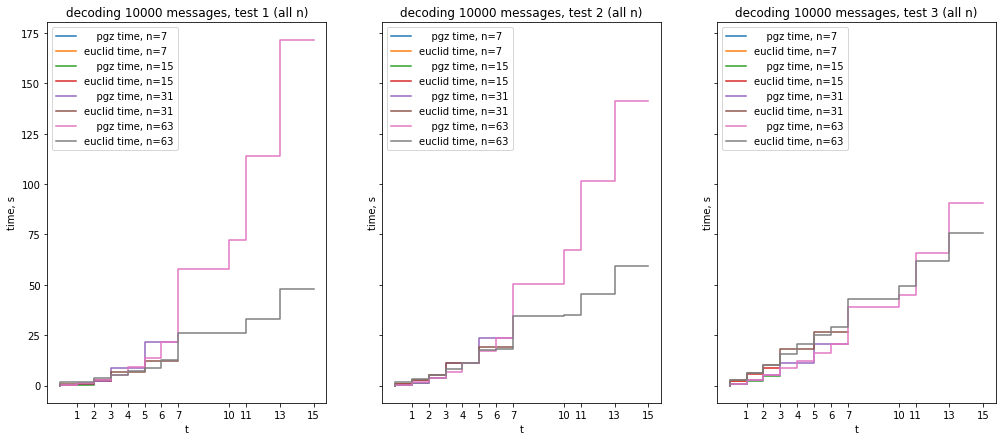

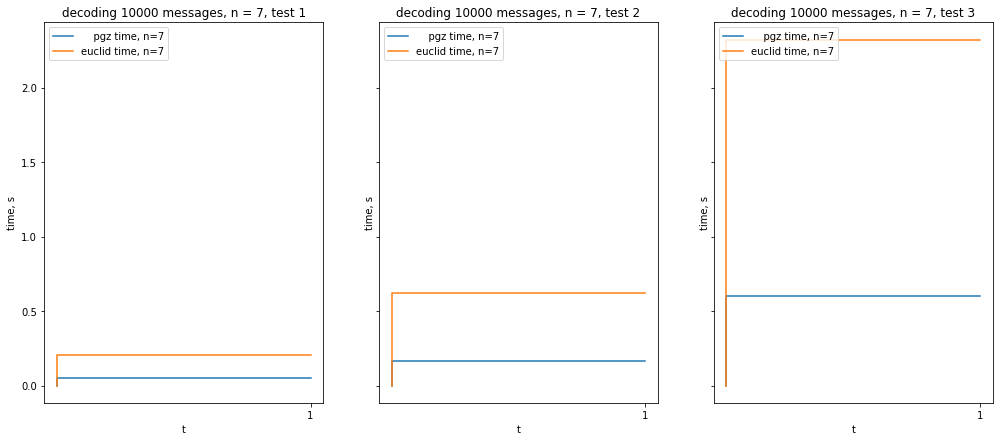

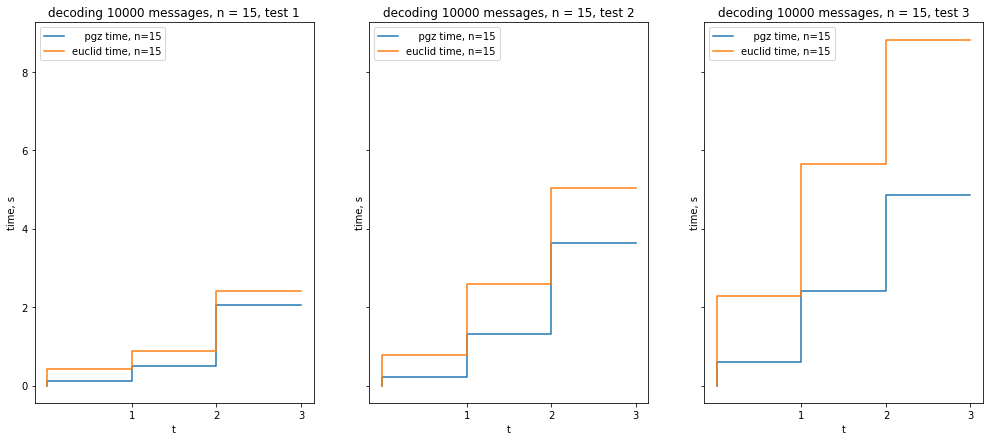

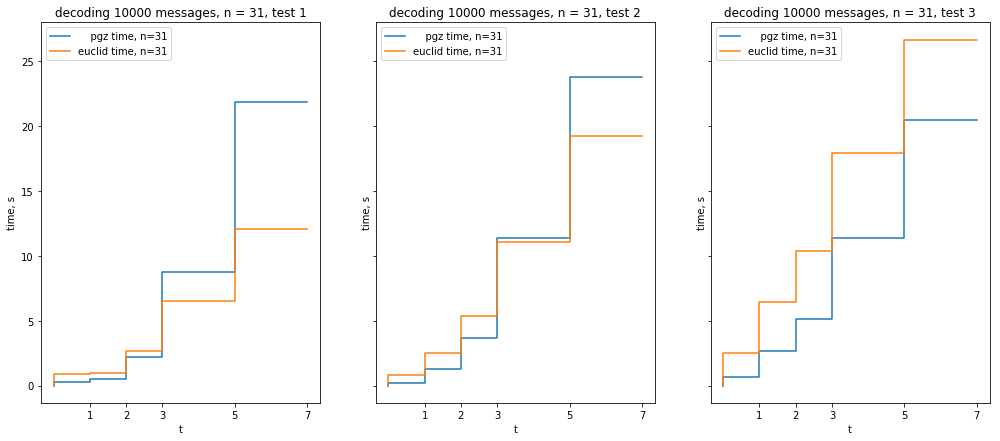

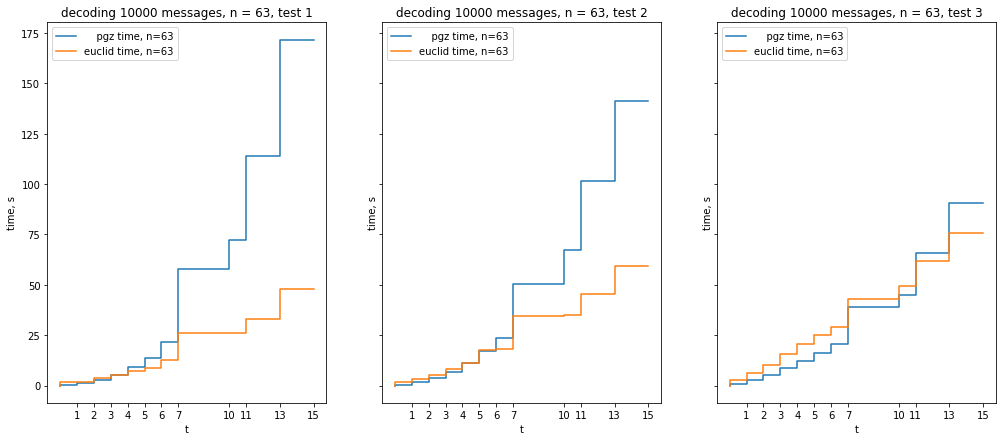

In [138]:
df_time = df_tests[["n", "t", "test", "pgz_time", "euclid_time"]]
fig, axes = [0]*(len(n_list)+1), [0]*(len(n_list)+1)
all_t = [0]*(len(n_list)+1)
all_t[0] = df_tests.t.unique()
for i in range(len(n_list)+1):
    fig[i], axes[i] = plt.subplots(1, 3, sharey=True)
    fig[i].set_figheight(7)
    fig[i].set_figwidth(17)
    if i != 0:
        all_t[i] = df_tests[df_tests.n == n_list[i - 1]].t.unique()
    for test in range(1, 3 + 1):
        if i == 0:
            axes[i][test-1].set_title(f'decoding {n_msg} messages, test {test} (all n)')
        else:
            axes[i][test-1].set_title(f'decoding {n_msg} messages, n = {n_list[i-1]}, test {test}')
        axes[i][test-1].set_xlabel('t')
        axes[i][test-1].set_ylabel(f'time, s')
        axes[i][test-1].set_xticks(all_t[i])
for test in range(1, 3 + 1):
    for n_idx, n in enumerate(n_list):
        df_cur = df_time[(df_time.test == test) & (df_time.n == n)]
        first0 = lambda arr: np.concatenate(([0], arr))
        plot_rows = [0, n_idx + 1]
        for i in plot_rows:
            axes[i][test-1].step(first0(df_cur.t.values),
                               first0(df_cur.pgz_time.values),
                               label=f'    pgz time, n={n}')
            axes[i][test-1].step(first0(df_cur.t.values),
                               first0(df_cur.euclid_time.values),
                               label=f'euclid time, n={n}')
            axes[i][test-1].legend(loc='upper left')

In [139]:
df_bars = df_tests[["n", "t", "test", "pgz_err_ratio"]]
df_b = df_bars[df_bars.test==2].drop(columns="test").rename(columns={"pgz_err_ratio":"test2_err_ratio"})
df_b["test3_err_ratio"] = df_bars[df_bars.test==3].pgz_err_ratio.values

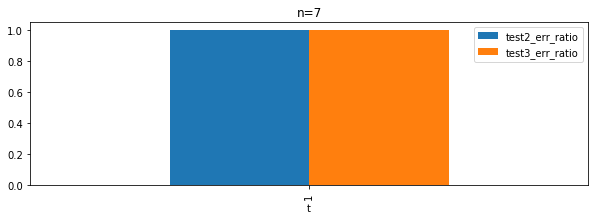

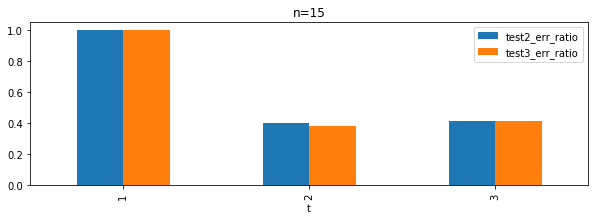

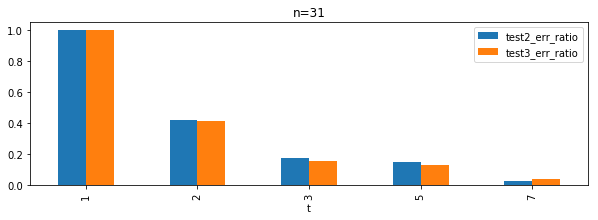

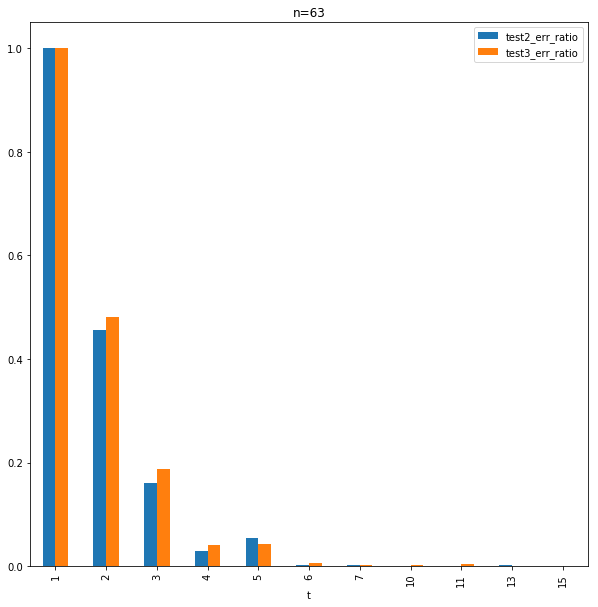

In [140]:
for n_idx, n in enumerate(n_list):
    df_b[df_b.n == n].drop(columns='n').plot.bar(
        x='t', title=f'n={n}', figsize=(10,3) if n < 63 else (10,10)
    )
plt.subplots_adjust(wspace=0.15, hspace=0.25) 